# Convolutional Neural Networks

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from sklearn import metrics
from sklearn import decomposition
from sklearn import manifold
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time

We need to set a random seed to ensure consistent results

In [2]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

Download the dataset - we will use `FashionMNIST`

In [3]:
ROOT = '.data'

train_data = datasets.FashionMNIST(root=ROOT,
                            train=True,
                            download=True)

## Normalize the data

<Descriptions>

In [4]:
mean = train_data.data.float().mean() / 255
std = train_data.data.float().std() / 255

train_transforms = transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize(mean=[mean], std=[std])
                                      ])

test_transforms = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[mean], std=[std])
                                      ])

In [5]:
train_data = datasets.FashionMNIST(root=ROOT,
                            train=True,
                            download=True,
                            transform=train_transforms)

test_data = datasets.FashionMNIST(root=ROOT,
                           train=False,
                           download=True,
                           transform=test_transforms)

## Take a look at the data

Its always a good idea to look a bit at the data. Here is a helper function to plot a set of the data.

In [6]:
def plot_images(images):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure()
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        ax.imshow(images[i].view(28, 28).cpu().numpy(), cmap='bone')
        ax.axis('off')

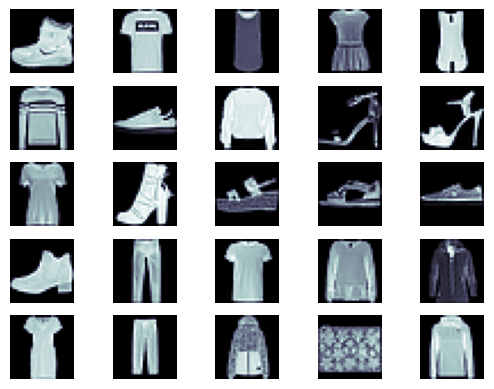

In [7]:
N_IMAGES = 25

images = [image for image, label in [train_data[i] for i in range(N_IMAGES)]]

plot_images(images)

In [8]:
VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data,
                                           [n_train_examples, n_valid_examples])

print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 54000
Number of validation examples: 6000
Number of testing examples: 10000


## 1. Build the network architecture

Our CNN contains two convolutional layers, each followed by a max-pooling layer and a batch-normalisation layer, and then a dense layer with dropout and finally the output layer. The network architecture is shown in the following figure ([figure source](https://mc.ai/the-convolution-parameters-calculation/)):

<img src="https://github.com/stfc-sciml/sciml-workshop/blob/master/course_3.0_with_solutions/markdown_pic/layer.jpeg?raw=1">


We have understood how a convolutional filter works. A convolutional layer is simply a collection of convolutional filters whose kernel values form the trainable parameters. The most frequently used kernel sizes are 3$\times$3, 5$\times$5 and 7$\times$7. The number of filters in each layer is a key network parameter governing the model size. 

The *max-pooling* layers are aimed for dimensionality reduction, containing no trainable parameters. It can be easily understood with the following illustration ([figure source](https://medium.com/ai-in-plain-english/pooling-layer-beginner-to-intermediate-fa0dbdce80eb)). The most common size for max pooling is 2$\times$2.

<img src="https://github.com/stfc-sciml/sciml-workshop/blob/master/course_3.0_with_solutions/markdown_pic/maxpooling.png?raw=1" width="50%">

The *batch-normalisation* layers can help the CNN to converge faster and become more stable through normalisation of the input layer by re-centering and re-scaling.

## Set up the network

In `pytorch` we build networks as a class. The example below is the minimal format for setting up a network in `pytorch`

* Declare the class - it should be a subclass of the `nn.Module` class from `pytorch`
* Define what inputs it takes upon declaration - in this case `input_dim` and `output_dim`
* `super` makes sure it inherits attributes from `nn.Module`
* We then define the different types of layers that we will use in this case three different linear layers
* Then we define a method `forward` which is what gets called when data is passed through the network, this basically moves the data `x` through the layers

Below we start the class, now write the forward function, we provide the first command, after this you should:
* perform a `maxpool` using a $2\times2$ filter
* pass through ReLU
* apply the second convolutional filter
* perform a `maxpool` using a $2\times2$ filter
* pass through ReLU
* reshape, using: `x = x.view(x.shape[0], -1)`
* pass through the first fully connected layer
* pass through `ReLU`
* pass through the second fully connected layer
* pass through `ReLU`
* pass through the third fully connected layer


**Suggested Answer** 

<details> <summary>Show / Hide</summary> 
<p>
    
```python
    def forward(self, x):

        x = self.conv1(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = F.relu(x)
        x = x.view(x.shape[0], -1)
        x = self.fc_1(x)
        x = F.relu(x)
        x = self.fc_2(x)
        x = F.relu(x)
        x = self.fc_3(x)

        return x
```
</p>
</details>

In [9]:
class LeNet(nn.Module):
    def __init__(self, output_dim):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=1,
                               out_channels=6,
                               kernel_size=5)

        self.conv2 = nn.Conv2d(in_channels=6,
                               out_channels=16,
                               kernel_size=5)

        self.fc_1 = nn.Linear(16 * 4 * 4, 120)
        self.fc_2 = nn.Linear(120, 84)
        self.fc_3 = nn.Linear(84, output_dim)

    def forward(self, x):

        x = self.conv1(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = F.relu(x)
        x = x.view(x.shape[0], -1)
        x = self.fc_1(x)
        x = F.relu(x)
        x = self.fc_2(x)
        x = F.relu(x)
        x = self.fc_3(x)

        return x

Now use this class to build a network

In [10]:
OUTPUT_DIM = 10

model = LeNet(OUTPUT_DIM)

## Training the Model

Next, we'll define our optimizer. This is the algorithm we will use to update the parameters of our model with respect to the loss calculated on the data.

We aren't going to go into too much detail on how neural networks are trained (see [this](http://neuralnetworksanddeeplearning.com/) article if you want to know how) but the gist is:
- pass a batch of data through your model
- calculate the loss of your batch by comparing your model's predictions against the actual labels
- calculate the gradient of each of your parameters with respect to the loss
- update each of your parameters by subtracting their gradient multiplied by a small *learning rate* parameter

We use the *Adam* algorithm with the default parameters to update our model. Improved results could be obtained by searching over different optimizers and learning rates, however default Adam is usually a good starting off point. Check out [this](https://ruder.io/optimizing-gradient-descent/) article if you want to learn more about the different optimization algorithms commonly used for neural networks.

Then, we define a *criterion*, PyTorch's name for a loss/cost/error function. This function will take in your model's predictions with the actual labels and then compute the loss/cost/error of your model with its current parameters.

`CrossEntropyLoss` both computes the *softmax* activation function on the supplied predictions as well as the actual loss via *negative log likelihood*. 

Briefly, the softmax function is:

$$\text{softmax }(\mathbf{x}) = \frac{e^{x_i}}{\sum_j e^{x_j}}$$ 

This turns out 10 dimensional output, where each element is an unbounded real number, into a probability distribution over 10 elements. That is, all values are between 0 and 1, and together they all sum to 1. 

Why do we turn things into a probability distribution? So we can use negative log likelihood for our loss function, as it expects probabilities. PyTorch calculates negative log likelihood for a single example via:

$$\text{negative log likelihood }(\mathbf{\hat{y}}, y) = -\log \big( \text{softmax}(\mathbf{\hat{y}})[y] \big)$$

$\mathbf{\hat{y}}$ is the $\mathbb{R}^{10}$ output, from our neural network, whereas $y$ is the label, an integer representing the class. The loss is the negative log of the class index of the softmax. For example:

$$\mathbf{\hat{y}} = [5,1,1,1,1,1,1,1,1,1]$$

$$\text{softmax }(\mathbf{\hat{y}}) = [0.8585, 0.0157, 0.0157, 0.0157, 0.0157, 0.0157, 0.0157, 0.0157, 0.0157, 0.0157]$$

If the label was class zero, the loss would be:

$$\text{negative log likelihood }(\mathbf{\hat{y}}, 0) = - \log(0.8585) = 0.153 \dots$$

If the label was class five, the loss would be:

$$\text{negative log likelihood }(\mathbf{\hat{y}}, 5) = - \log(0.0157) = 4.154 \dots$$

So, intuitively, as your model's output corresponding to the correct class index increases, your loss decreases.

In [11]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

## Look for GPUs

In toorch the code automatically defaults to run on cpu. You can check for avialible gpus, then move all of the code across to GPU if you like.

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = criterion.to(device)

In [13]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

## Set up the batches

We will do mini-batch gradient descent with Adam. So we can set up the batch sizes 

In [14]:
BATCH_SIZE = 64

train_iterator = data.DataLoader(train_data,
                                 shuffle=True,
                                 batch_size=BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data,
                                 batch_size=BATCH_SIZE)

test_iterator = data.DataLoader(test_data,
                                batch_size=BATCH_SIZE)

We finally define our training loop.

This will:

    put our model into train mode
    iterate over our dataloader, returning batches of (image, label)
    place the batch on to our GPU, if we have one
    clear the gradients calculated from the last batch
    pass our batch of images, x, through to model to get predictions, y_pred
    calculate the loss between our predictions and the actual labels
    calculate the accuracy between our predictions and the actual labels
    calculate the gradients of each parameter
    update the parameters by taking an optimizer step
    update our metrics

Some layers act differently when training and evaluating the model that contains them, hence why we must tell our model we are in "training" mode. The model we are using here does not use any of those layers, however it is good practice to get used to putting your model in training mode.


In [23]:
def train(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for (x, y) in tqdm(iterator, desc="Training", leave=False):

        x = x.to(device)              # Move the data to the device where you want to compute
        y = y.to(device)

        optimizer.zero_grad()         # Initialise the optimiser

        y_pred = model(x)          # Obtain initial predictions

        loss = criterion(y_pred, y)   # Calculate the loss

        acc = calculate_accuracy(y_pred, y)

        loss.backward()               # Backprop the loss to update the weights

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [24]:
def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [25]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [26]:
EPOCHS = 10

best_valid_loss = float('inf')

for epoch in trange(EPOCHS):

    start_time = time.monotonic()

    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

  0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 19s
	Train Loss: 0.224 | Train Acc: 91.53%
	 Val. Loss: 0.319 |  Val. Acc: 88.67%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 19s
	Train Loss: 0.214 | Train Acc: 91.82%
	 Val. Loss: 0.316 |  Val. Acc: 88.57%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 19s
	Train Loss: 0.204 | Train Acc: 92.39%
	 Val. Loss: 0.330 |  Val. Acc: 88.59%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 19s
	Train Loss: 0.194 | Train Acc: 92.70%
	 Val. Loss: 0.303 |  Val. Acc: 89.07%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 20s
	Train Loss: 0.186 | Train Acc: 92.97%
	 Val. Loss: 0.319 |  Val. Acc: 88.37%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 15s
	Train Loss: 0.181 | Train Acc: 93.16%
	 Val. Loss: 0.324 |  Val. Acc: 88.73%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 15s
	Train Loss: 0.171 | Train Acc: 93.57%
	 Val. Loss: 0.366 |  Val. Acc: 88.18%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 15s
	Train Loss: 0.166 | Train Acc: 93.65%
	 Val. Loss: 0.331 |  Val. Acc: 88.81%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 16s
	Train Loss: 0.160 | Train Acc: 94.02%
	 Val. Loss: 0.342 |  Val. Acc: 88.63%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 16s
	Train Loss: 0.154 | Train Acc: 94.16%
	 Val. Loss: 0.345 |  Val. Acc: 89.18%


## Try on the test set

In [19]:
model.load_state_dict(torch.load('tut1-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion, device)

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

In [20]:
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.299 | Test Acc: 89.47%


## Try out on a rotated test set

1. Add rotations to the test data and see how well the model performs. 

You add rotations in the transforms, so declare a new transform and a new test data set:

```python

roated_test_transforms = transforms.Compose([
                           transforms.RandomRotation(25, fill=(0,)),
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[mean], std=[std])
                                      ])

rotated_test_data = datasets.FashionMNIST(root=ROOT,
                           train=False,
                           download=True,
                           transform=roated_test_transforms)

rotated_test_iterator = data.DataLoader(rotated_test_data,
                                batch_size=BATCH_SIZE)
```
2. Now go to the exercises in the DNN notebook, do the same rotations and compare the performance of the two models.

In [21]:
roated_test_transforms = transforms.Compose([
                           transforms.RandomRotation(25, fill=(0,)),
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[mean], std=[std])
                                      ])

rotated_test_data = datasets.FashionMNIST(root=ROOT,
                           train=False,
                           download=True,
                           transform=roated_test_transforms)

rotated_test_iterator = data.DataLoader(rotated_test_data,
                                batch_size=BATCH_SIZE)

In [22]:
model.load_state_dict(torch.load('tut1-model.pt'))

test_loss, test_acc = evaluate(model, rotated_test_iterator, criterion, device)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 1.058 | Test Acc: 67.67%
